In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import talib
from sklearn.cluster import KMeans
from scipy.stats import shapiro
import warnings

warnings.filterwarnings('ignore')

In [2]:
df=pd.read_excel("Dados2.xlsx")
df.head(5)

,Tipo De Registro,Data Do Pregão,Cod BDI,CODNEG,Tipo de Mercado,NOMRES,Especificação Do Papel,PRAZOT,Moeda De Referencia,PREABE,...,TOTNEG,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES
0,1,2024-01-02,2,ABCB4,10,ABC BRASIL,PN EJS N2,NaN,R$,2398,...,19447,44947308,0,0,1999-12-31,1,0,BRABCBACNPR4,145,NaN
1,1,2024-01-02,2,ABEV3,10,AMBEV S/A,ON EJ,NaN,R$,1372,...,116902,159839111,0,0,1999-12-31,1,0,BRABEVACNOR1,127,NaN
2,1,2024-01-02,2,BBDC3,10,BRADESCO,ON EJ N1,NaN,R$,1526,...,45456,68576854,0,0,1999-12-31,1,0,BRBBDCACNOR1,764,NaN
3,1,2024-01-02,2,ALPA3,10,ALPARGATAS,ON N1,NaN,R$,1011,...,29,29120,0,0,1999-12-31,1,0,BRALPAACNOR0,231,NaN
4,1,2024-01-02,2,ALPA4,10,ALPARGATAS,PN N1,NaN,R$,1010,...,69070,67135028,0,0,1999-12-31,1,0,BRALPAACNPR7,232,NaN


In [3]:
dfSTD=df[["CODNEG","PREULT"]].groupby("CODNEG").std()
dfSTD

,PREULT
CODNEG,
5GTK11,692.179027
A1AP34,240.220531
A1CR34,322.295386
A1DI34,5711.646727
A1DM34,2753.098973
...,...
ZAMPP350,2.121320
ZAMPR370,31.785741
ZAVC11,2.143959


In [4]:
dfPETR3=df.query("CODNEG=='PETR3'")

In [5]:
dfPETR3[["CODNEG","PREULT"]].groupby("CODNEG").mean()

,PREULT
CODNEG,
PETR3,4039.572581


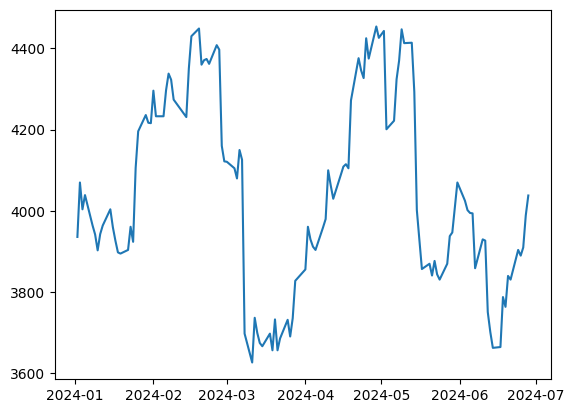

In [6]:
import matplotlib.pyplot as plt
eixoX=dfPETR3['Data Do Pregão']
eixoY=dfPETR3['PREULT']
plt.plot(eixoX,eixoY)
plt.show()

In [7]:
df = pd.read_excel("Dados2.xlsx")

# Conversão de datas
df['Data Do Pregão'] = pd.to_datetime(df['Data Do Pregão'], format='%Y%m%d')
df = df.set_index('Data Do Pregão')

# Normalização dos preços
df['PREULT_NORMALIZADO'] = df['PREULT'] / 100

# Filtra ações (Tipo de Mercado 10)
df_acoes = df[df['Tipo de Mercado'] == 10].copy()

# Cria tabelas pivotadas de preço e volume
df_fechamento = df_acoes.pivot_table(index='Data Do Pregão', columns='CODNEG', values='PREULT_NORMALIZADO')
df_volume = df_acoes.pivot_table(index='Data Do Pregão', columns='CODNEG', values='VOLTOT')

print("✅ Dados carregados com sucesso!")
print(df_fechamento.tail())


✅ Dados carregados com sucesso!
CODNEG          5GTK11  A1AP34  A1CR34  A1DI34  A1DM34  A1EE34  A1EG34  \
Data Do Pregão                                                           
2024-06-24      103.79   21.96   54.10  628.81  335.94     NaN   33.86   
2024-06-25      105.90     NaN     NaN  628.81     NaN     NaN   34.35   
2024-06-26      106.96   21.50   54.38     NaN  335.94     NaN     NaN   
2024-06-27      107.20   21.83   54.40     NaN  332.01     NaN   34.17   
2024-06-28      109.68   21.67     NaN     NaN  337.92     NaN   33.88   

CODNEG          A1EN34  A1EP34  A1ES34  ...  Z2DV34  Z2IT34  Z2LL34  Z2LL35  \
Data Do Pregão                          ...                                   
2024-06-24         NaN  236.64   101.5  ...     NaN     NaN     NaN     NaN   
2024-06-25         NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
2024-06-26         NaN     NaN     NaN  ...     NaN    8.79     NaN     NaN   
2024-06-27         NaN     NaN     NaN  ...     NaN   

Colunas retornadas por yfinance:
MultiIndex([( 'Close', '^BVSP'),
            (  'High', '^BVSP'),
            (   'Low', '^BVSP'),
            (  'Open', '^BVSP'),
            ('Volume', '^BVSP')],
           names=['Price', 'Ticker'])
⚠️ Nenhuma coluna 'Adj Close' ou 'Close' encontrada — usando '^BVSP'.


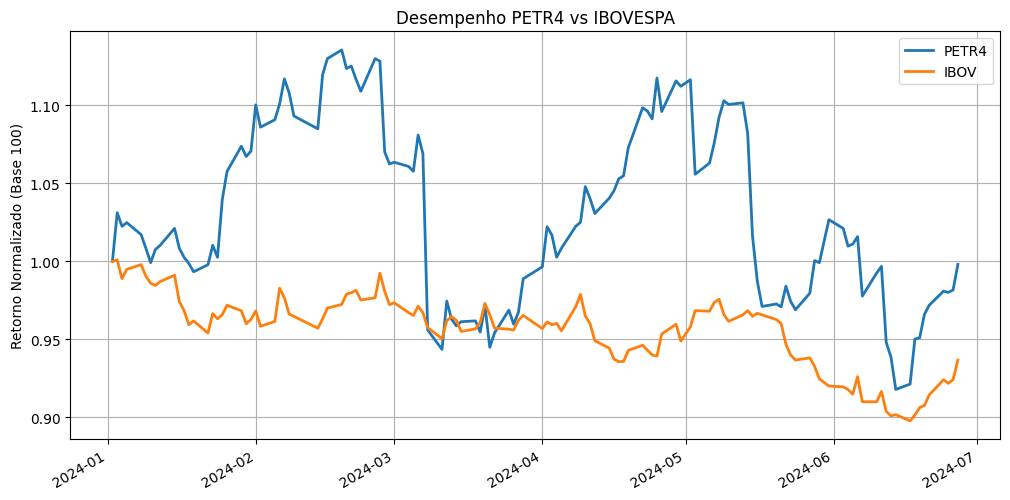

In [9]:
# Comparar com IBOVESPA
data_ini, data_fim = df_fechamento.index.min(), df_fechamento.index.max()

# Faz o download dos dados do Ibovespa (^BVSP)
ibov_data = yf.download('^BVSP', start=data_ini, end=data_fim, progress=False)

# 🔍 Diagnóstico: mostra como o yfinance retornou as colunas
print("Colunas retornadas por yfinance:")
print(ibov_data.columns)

# 🔧 Corrige caso o retorno seja MultiIndex
if isinstance(ibov_data.columns, pd.MultiIndex):
    ibov_data.columns = ibov_data.columns.get_level_values(-1)

# 📈 Escolhe a melhor coluna disponível
if 'Adj Close' in ibov_data.columns:
    ibov = ibov_data['Adj Close']
elif 'Close' in ibov_data.columns:
    ibov = ibov_data['Close']
else:
    # Fallback — pega a primeira coluna numérica (raro, mas evita erro)
    ibov = ibov_data.select_dtypes(include=[np.number]).iloc[:, 0]
    print(f"⚠️ Nenhuma coluna 'Adj Close' ou 'Close' encontrada — usando '{ibov.name}'.")

# Cria o DataFrame de comparação PETR4 x IBOV
df_bench = pd.DataFrame({'PETR4': df_fechamento['PETR4'], 'IBOV': ibov}).dropna()

# Calcula retorno acumulado normalizado
bench_norm = (1 + df_bench.pct_change().fillna(0)).cumprod()
bench_norm /= bench_norm.iloc[0]

# Plota os resultados
bench_norm.plot(figsize=(12, 6), title='Desempenho PETR4 vs IBOVESPA', linewidth=2)
plt.ylabel('Retorno Normalizado (Base 100)')
plt.grid(True)
plt.show()


In [10]:
ativo_exemplo = 'PETR4'

if ativo_exemplo in df_volume.columns:
    df_vol = df_volume[[ativo_exemplo]].dropna()
    vol_medio = df_vol[ativo_exemplo].mean()
    print(f"Volume médio diário ({ativo_exemplo}): {vol_medio:,.0f}")

    df_pv = pd.DataFrame({
        'Preço': df_fechamento[ativo_exemplo],
        'Volume': df_vol[ativo_exemplo]
    }).dropna()
    corr = df_pv['Preço'].corr(df_pv['Volume'])
    print(f"Correlação Preço x Volume: {corr:.4f}")

    limite = vol_medio + 2 * df_vol[ativo_exemplo].std()
    dias_atipicos = df_vol[df_vol[ativo_exemplo] > limite]
    print("\nDias com volume atípico:")
    print(dias_atipicos)


Volume médio diário (PETR4): 0
Correlação Preço x Volume: nan

Dias com volume atípico:
Empty DataFrame
Columns: [PETR4]
Index: []


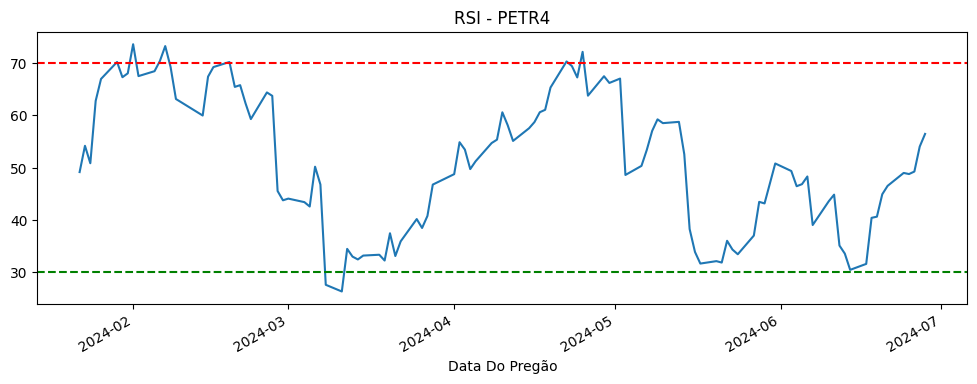

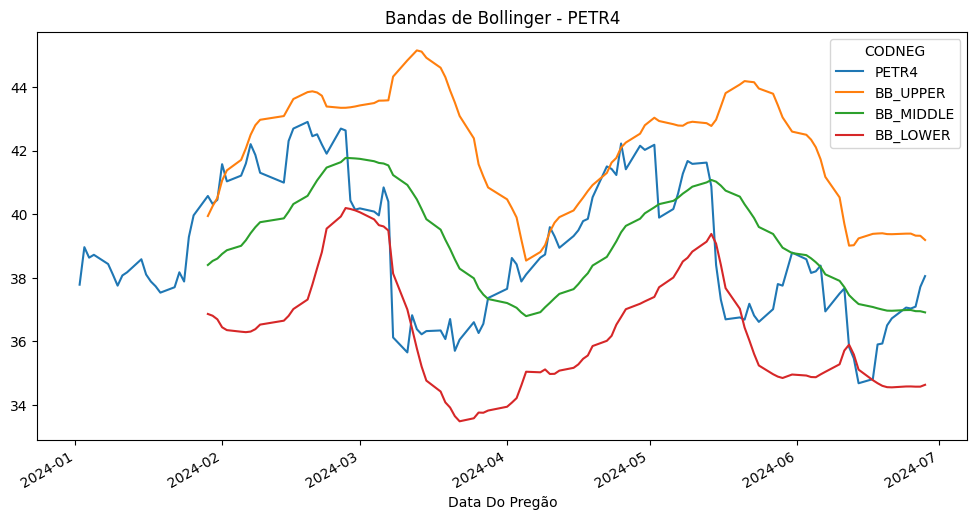

In [11]:
ativo_exemplo = 'PETR4'
if ativo_exemplo in df_fechamento.columns:
    df_ta = df_fechamento[[ativo_exemplo]].dropna()
    preco = df_ta[ativo_exemplo].values

    df_ta['RSI'] = talib.RSI(preco, timeperiod=14)
    upper, middle, lower = talib.BBANDS(preco, timeperiod=20)
    df_ta['BB_UPPER'], df_ta['BB_MIDDLE'], df_ta['BB_LOWER'] = upper, middle, lower
    df_ta['MACD'], _, _ = talib.MACD(preco)

    plt.figure(figsize=(12, 4))
    df_ta['RSI'].plot(title=f'RSI - {ativo_exemplo}')
    plt.axhline(70, color='r', linestyle='--')
    plt.axhline(30, color='g', linestyle='--')
    plt.show()

    df_ta[[ativo_exemplo, 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER']].plot(figsize=(12, 6), title=f'Bandas de Bollinger - {ativo_exemplo}')
    plt.show()


In [12]:
df_retornos = df_fechamento.pct_change().dropna()

ret_acum = (df_retornos + 1).prod() - 1
ret_medio_anual = df_retornos.mean() * 252
vol_anual = df_retornos.std() * np.sqrt(252)

taxa_rf = 0.10
sharpe = (ret_medio_anual - taxa_rf) / vol_anual

df_est = pd.DataFrame({
    'Retorno Acumulado': ret_acum,
    'Retorno Médio Anualizado': ret_medio_anual,
    'Volatilidade Anualizada': vol_anual,
    'Sharpe Ratio': sharpe
}).sort_values(by='Sharpe Ratio', ascending=False)

print("Top 10 ativos por Sharpe Ratio:")
print(df_est.head(10).applymap(lambda x: f'{x:.2%}'))


Top 10 ativos por Sharpe Ratio:
       Retorno Acumulado Retorno Médio Anualizado Volatilidade Anualizada  \
CODNEG                                                                      
5GTK11             0.00%                     nan%                    nan%   
A1AP34             0.00%                     nan%                    nan%   
A1CR34             0.00%                     nan%                    nan%   
A1DI34             0.00%                     nan%                    nan%   
A1DM34             0.00%                     nan%                    nan%   
A1EE34             0.00%                     nan%                    nan%   
A1EG34             0.00%                     nan%                    nan%   
A1EN34             0.00%                     nan%                    nan%   
A1EP34             0.00%                     nan%                    nan%   
A1ES34             0.00%                     nan%                    nan%   

       Sharpe Ratio  
CODNEG               

In [13]:
# Garantir que todos os ativos tenham valores válidos (sem NaN)
df_fechamento_preenchido = df_fechamento.fillna(method='ffill').fillna(method='bfill')

# Recalcular os retornos com base nesses dados completos
df_retornos = df_fechamento_preenchido.pct_change().dropna()


In [14]:
df_cluster = df_retornos.T.select_dtypes(include=[np.number]).fillna(0)

if len(df_cluster) >= 5:
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    kmeans.fit(df_cluster)
    clusters = pd.Series(kmeans.labels_, index=df_cluster.index)

    print(f"\n✅ Clustering concluído com sucesso!\n")
    for i in range(5):
        grupo = clusters[clusters == i]
        print(f"Cluster {i}: {len(grupo)} ativos")
        print("Exemplos:", grupo.head(10).index.tolist(), "\n")
else:
    print("⚠️ Ainda há poucos ativos válidos para clustering.")



✅ Clustering concluído com sucesso!

Cluster 0: 1 ativos
Exemplos: ['BGIP2'] 

Cluster 1: 1 ativos
Exemplos: ['SEQL3'] 

Cluster 2: 1 ativos
Exemplos: ['AERI3'] 

Cluster 3: 3 ativos
Exemplos: ['AMAR1', 'OIBR3', 'OIBR4'] 

Cluster 4: 2041 ativos
Exemplos: ['5GTK11', 'A1AP34', 'A1CR34', 'A1DI34', 'A1DM34', 'A1EE34', 'A1EG34', 'A1EN34', 'A1EP34', 'A1ES34'] 



In [15]:
ativo_exemplo = 'PETR4'
if ativo_exemplo in df_retornos.columns:
    ret = df_retornos[ativo_exemplo].dropna()
    if 3 < len(ret) <= 5000:
        stat, p = shapiro(ret)
        print(f"Estatística: {stat:.4f}, p-valor: {p:.4f}")
        if p > 0.05:
            print("Os retornos seguem uma distribuição normal (p > 0.05).")
        else:
            print("Os retornos NÃO seguem uma distribuição normal (p ≤ 0.05).")
    else:
        print("Amostra inadequada para o teste de Shapiro-Wilk.")


Estatística: 0.8701, p-valor: 0.0000
Os retornos NÃO seguem uma distribuição normal (p ≤ 0.05).


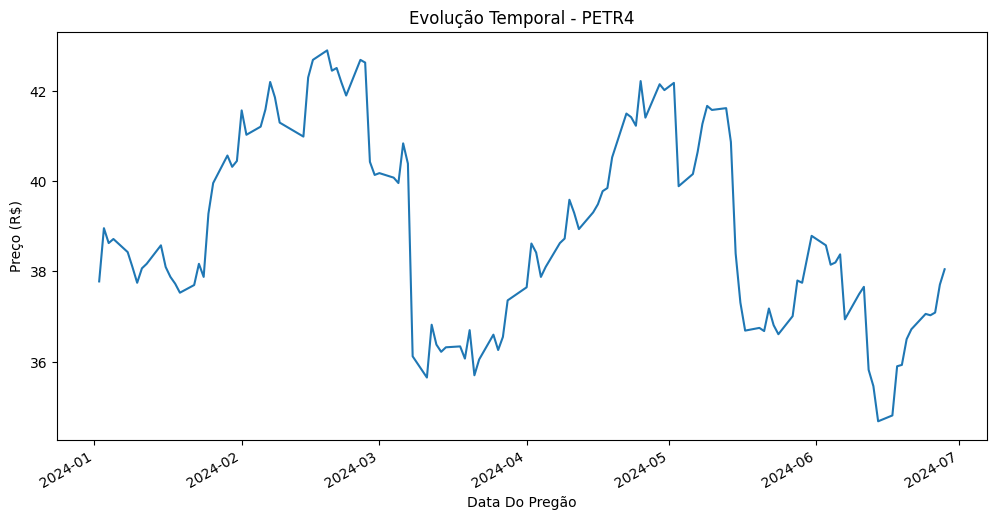

Volatilidade Anualizada (PETR4): 30.83%


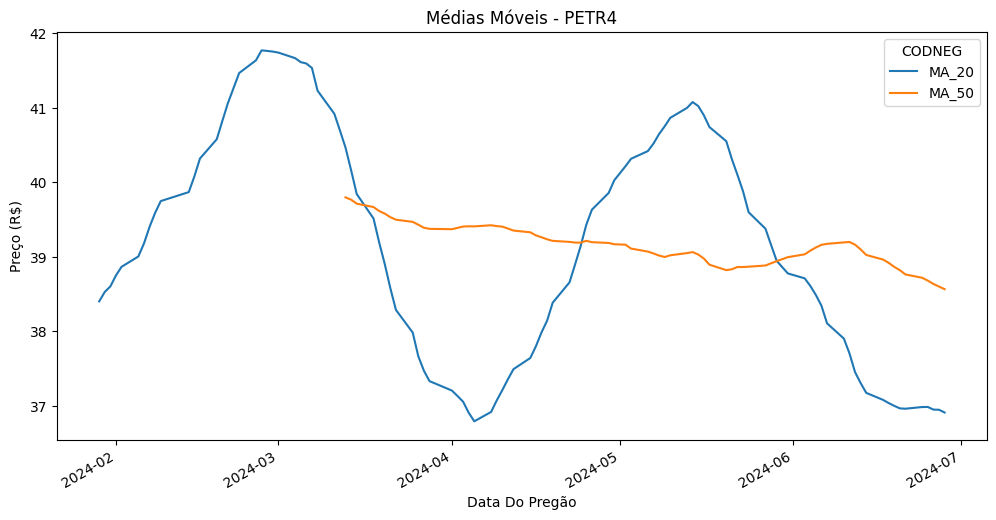

In [ ]:
ativo_exemplo = 'PETR4'

if ativo_exemplo in df_fechamento.columns:
    df_ativo = df_fechamento[[ativo_exemplo]].dropna()

    # Gráfico de preço
    plt.figure(figsize=(12, 6))
    df_ativo[ativo_exemplo].plot(title=f'Evolução Temporal - {ativo_exemplo}')
    plt.ylabel('Preço (R$)')
    plt.show()

    # Volatilidade anualizada
    retornos_diarios = df_ativo[ativo_exemplo].pct_change().dropna()
    vol_anu = retornos_diarios.std() * np.sqrt(252)
    print(f"Volatilidade Anualizada ({ativo_exemplo}): {vol_anu:.2%}")

    # Médias móveis
    df_ativo['MA_20'] = df_ativo[ativo_exemplo].rolling(20).mean()
    df_ativo['MA_50'] = df_ativo[ativo_exemplo].rolling(50).mean()

    df_ativo[['MA_20', 'MA_50']].plot(figsize=(12, 6), title=f'Médias Móveis - {ativo_exemplo}')
    plt.ylabel('Preço (R$)')
    plt.show()
else:
    print(f"Ativo {ativo_exemplo} não encontrado.")
